# Import required libraries

In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import matplotlib.pyplot as plt
import collections
import itertools
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## extract digit_recognizer.zip into the data folder

Load csv files using pandas

In [2]:
!mkdir -p data
with ZipFile('digit-recognizer.zip', 'r') as zipObj:
   zipObj.extractall('data')

In [3]:
test_data = pd.read_csv('./data/test.csv')
train_data = pd.read_csv('./data/train.csv')

## Investigate the balance of the data for each label

<BarContainer object of 10 artists>

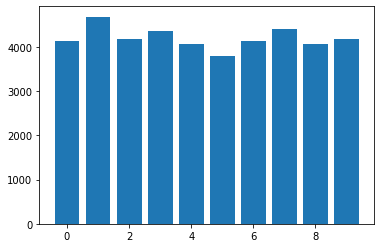

In [4]:
labels = train_data.label.values
label_count = collections.Counter(labels)
plt.bar(label_count.keys(), label_count.values())

# Prepare images by reshaping and normalizing values

In [5]:
train_data.drop(columns={'label'}, inplace=True)
train_data /= 255.
test_data /= 255.

In [6]:
test_images = np.reshape(test_data.values, (test_data.shape[0],28,28,1))
train_images = np.reshape(train_data.values, (train_data.shape[0],28,28,1))
test_images[0].shape

(28, 28, 1)

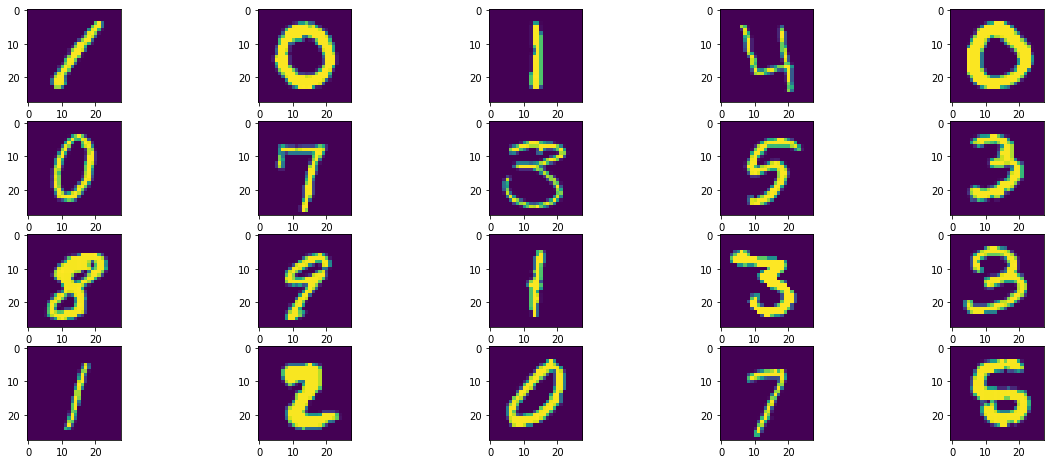

In [7]:
plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(train_images[:20]):
    plt.subplot(len(train_images[:20]) / columns + 1, columns, i + 1)
    plt.imshow(image[:,:,0])

## Split the train and the validation set for the fitting

In [9]:
X_train, X_val, Y_train, Y_val = train_test_split(train_images, labels, test_size=0.2, random_state=4)

# Build the CNN model

In [10]:
def create_model(print_summary=False):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(28,28,1)))
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
    model.add(MaxPool2D(pool_size=2, strides=2))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
    model.add(MaxPool2D(pool_size=2, strides=2))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(0.25))
    model.add(Dense(10, activation = "softmax"))
    
    opt = Adam(lr=0.001)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    
    if print_summary:
        model.summary()
    return model 

In [11]:
model = create_model()
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=0.00001)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 128)         73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 128)         0

# Build the data generator and train the model

In [12]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.1)

datagen.fit(X_train)

In [13]:
BS = 128
history = model.fit(datagen.flow(X_train, Y_train, batch_size=BS), steps_per_epoch= X_train.shape[0] // BS, 
                    validation_data=(X_val, Y_val), epochs=50, verbose=2, callbacks=[reduce_lr])

[INFO] training model...
Train for 262 steps, validate on 8400 samples
Epoch 1/50
262/262 - 59s - loss: 0.9506 - accuracy: 0.6745 - val_loss: 0.1307 - val_accuracy: 0.9610
Epoch 2/50
262/262 - 59s - loss: 0.3173 - accuracy: 0.8997 - val_loss: 0.0665 - val_accuracy: 0.9794
Epoch 3/50
262/262 - 57s - loss: 0.2110 - accuracy: 0.9363 - val_loss: 0.0723 - val_accuracy: 0.9768
Epoch 4/50
262/262 - 57s - loss: 0.1706 - accuracy: 0.9472 - val_loss: 0.0440 - val_accuracy: 0.9862
Epoch 5/50
262/262 - 58s - loss: 0.1413 - accuracy: 0.9567 - val_loss: 0.0424 - val_accuracy: 0.9863
Epoch 6/50
262/262 - 64s - loss: 0.1224 - accuracy: 0.9631 - val_loss: 0.0414 - val_accuracy: 0.9865
Epoch 7/50
262/262 - 63s - loss: 0.1115 - accuracy: 0.9661 - val_loss: 0.0443 - val_accuracy: 0.9863
Epoch 8/50
262/262 - 65s - loss: 0.1052 - accuracy: 0.9683 - val_loss: 0.0455 - val_accuracy: 0.9880
Epoch 9/50
262/262 - 62s - loss: 0.0960 - accuracy: 0.9701 - val_loss: 0.0403 - val_accuracy: 0.9893
Epoch 10/50
262/262 

# Plot loss and accuracy for training and validation

<Figure size 1440x720 with 0 Axes>

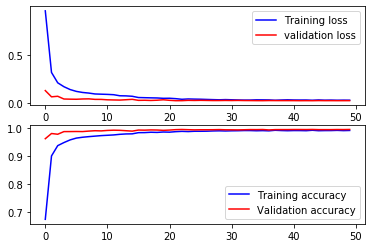

In [15]:
plt.figure(figsize=(20,10))
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
ax[0].legend()

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax[1].legend()

# Plot Confusion matrix for the validation data

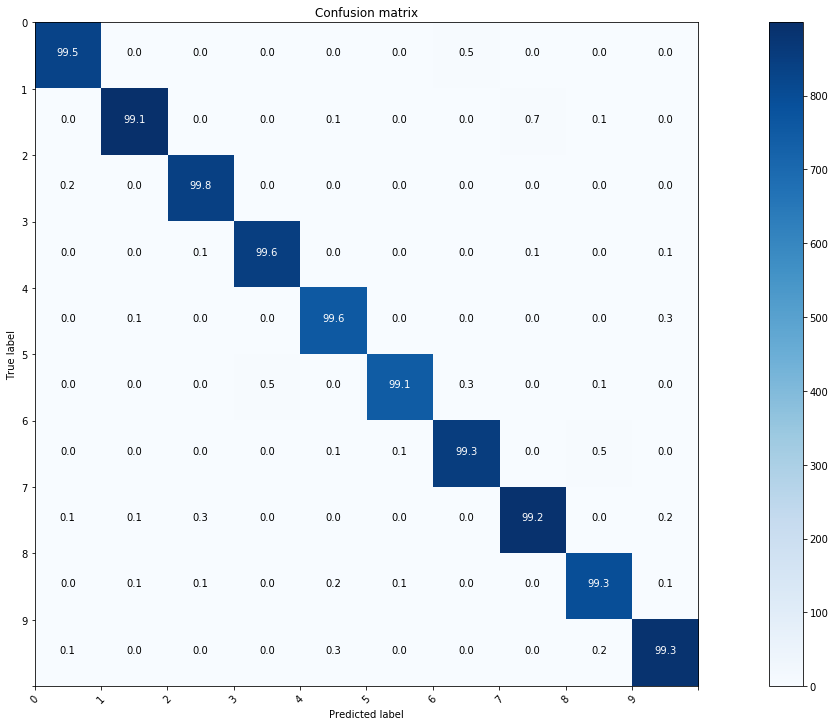

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure(figsize=(20,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(-0.5, len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],1)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# # Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_val, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10), normalize=True)

In [23]:
print(classification_report(Y_val, Y_pred_classes))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       834
           1       1.00      0.99      0.99       907
           2       0.99      1.00      1.00       843
           3       1.00      1.00      1.00       851
           4       0.99      1.00      0.99       761
           5       1.00      0.99      0.99       753
           6       0.99      0.99      0.99       858
           7       0.99      0.99      0.99       898
           8       0.99      0.99      0.99       803
           9       0.99      0.99      0.99       892

    accuracy                           0.99      8400
   macro avg       0.99      0.99      0.99      8400
weighted avg       0.99      0.99      0.99      8400



# prepate kaggle submission file

In [24]:
# predict results
results = model.predict(test_images)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

submission = pd.DataFrame({
    'ImageID': range(1, len(results) + 1),
    'Label': results
})
submission.to_csv("digit_recognizer_cnn.csv",index=False)